────────────────────────────────────────────────────────────
# 🐍 <font color = green> **Python-Based Script (Runtime Type)**<font/>


────────────────────────────────────────────────────────────


# █▓▒░ 📦 **1 Python Packages Installation** ░▒▓█


In [ ]:
!pip install pyffp
!pip install geopy
!pip install geojsoncontour
!pip install tqdm
!pip install semopy
!pip install graphviz
!pip install pydotplus
!sudo apt-get install graphviz
!pip install windrose

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


# █▓▒░ 📦 **2 Importing Python Packages** ░▒▓█

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
from numpy import nan
import time
import math

import matplotlib.dates as mdates  # Importing mdates module
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import matplotlib.cm as cm
from pyffp import calc_footprint_FFP_climatology as myfootprint
from pyffp.utils import get_dd
from pyffp.utils import contour_to_gdf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import ttest_ind, ttest_rel

import semopy
import matplotlib.pyplot as plt
from IPython.display import Image
from semopy import Model  # Only use the `Model` class
from graphviz import Digraph

from windrose import WindroseAxes

from tqdm import tqdm  # Import tqdm
#from google.colab import files

import warnings
warnings.filterwarnings("ignore")

# █▓▒░ 📦 **3 Data Reading** ░▒▓█

## 【🌿 CO₂】 **3.1 Full Output and Biomet Data**


In [ ]:
# Unit rows sepearation (first 3 rows) for Google Earth Engine
co2_flux_2021_unit = pd.read_csv("eddypro_2021_full_output_2024-03-21T173624_adv.csv")        # flux data
units =co2_flux_2021_unit.iloc[:2, :]

biomet_2021_unit = pd.read_csv("eddypro_2021_biomet_2024-03-20T231200_adv.csv")       # biomet file units
biomet_units = biomet_2021_unit.iloc[:1, :]


# Flux
co2_flux_2021 = pd.read_csv("eddypro_2021_full_output_2024-03-21T173624_adv.csv", skiprows =[0,2])


# Biomet
co2_biomet_2021 = pd.read_csv("eddypro_2021_biomet_2024-03-20T231200_adv.csv", skiprows =[1])

# █▓▒░ 📦 **4 Data processing** ░▒▓█

## 【🕒】 **4.1 Datetime Formatting**


In [159]:
co2_flux_2021['datetime'] = pd.to_datetime(co2_flux_2021["date"] + ' ' + co2_flux_2021['time'], format='%Y-%m-%d %H:%M')
co2_biomet_2021['datetime'] = pd.to_datetime(co2_biomet_2021["date"] + ' ' + co2_biomet_2021['time'], format='%Y-%m-%d %H:%M')

# Set datetime as index for Flux data
co2_flux_2021.set_index('datetime', inplace=True)
# Set datetime as index for Biomet data
co2_biomet_2021.set_index('datetime', inplace=True)

## 【🔗】 **2.3 Concatenation (Flux & Biomet Data)**


In [160]:
# Concatenate concatenated Flux and Biomet DataFrames along columns
co2_df = pd.concat([co2_flux_2021, co2_biomet_2021], axis=1)
# Print the shape of the merged DataFrame
print("Merged DataFrame Shape:", co2_df.shape)

# data measurement timeframe
print(f"Data measurement starts on: {co2_df.index.min()}")
print(f"Data measurement ends on: {co2_df.index.max()}")

Merged DataFrame Shape: (14502, 235)
Data measurement starts on: 2021-03-04 21:00:00
Data measurement ends on: 2021-12-31 23:30:00


## 🔍 **2.4 Data Continuity Check**



**Continuous Half-hourly data checking: Checking the presence of continuous half-hourly interval (optional: possibility to see the missing measurements)**

In [161]:
# Checking the presence of continuous hlf-hourly data
start_time = co2_df.index.min()
end_time = co2_df.index.max()
# Check for half-hour intervals
expected_interval = pd.Timedelta(minutes=30)
current_time = start_time
missing_intervals = False  # Flag to indicate missing intervals
while current_time < end_time:
    if current_time not in co2_df.index:
        missing_intervals = True
        break
    current_time += expected_interval
# Check if missing_intervals flag is True or False
if missing_intervals:
    print("\nNot every half-hour interval is present in the dataset index.")
else:
    print("\nEvery half-hour interval is present in the dataset index.")

# Checking missing values
#print(f"\nMissing values:\n {list(co2_df.isnull().sum().items())}", end='')                   # missing measurements


Every half-hour interval is present in the dataset index.


**Creation of continuous half-hourly interval**

In [162]:
print(f"Measurement starts: {co2_df.index.min()}")
print(f"Measurement ends: {co2_df.index.max()}")

# Creating a continuous half-hourly data
# Create a continuous half-hourly datetime index
start_datetime = co2_df.index.min()
end_datetime = co2_df.index.max()
half_hourly_index = pd.date_range(start=start_datetime, end=end_datetime, freq='30min')
# Create a DataFrame with the continuous half-hourly index and NaN values in the NEE column
df_continuous = pd.DataFrame(index=half_hourly_index)
# Print the minimum and maximum timestamps of the continuous index
print("\nMinimum Timestamp (Continuous):", df_continuous.index.min())
print("Maximum Timestamp (Continuous):", df_continuous.index.max())
print(f"\nShape of the CO2 FluxBiomet data: {df_continuous.shape}")

# Concating the CO2 FluxBiomet data and Continuous half-hourly interval
df_continuous_30mins = pd.concat([co2_df, df_continuous], axis=1)
df_continuous_30mins.shape

# Making a copy of the FluxBiomet dataset
co2_df = df_continuous_30mins.copy()

# Checking the presence of continuous hlf-hourly data
start_time = co2_df.index.min()
end_time = co2_df.index.max()
# Check for half-hour intervals
expected_interval = pd.Timedelta(minutes=30)
current_time = start_time
missing_intervals = False  # Flag to indicate missing intervals
while current_time < end_time:
    if current_time not in co2_df.index:
        missing_intervals = True
        break
    current_time += expected_interval
# Check if missing_intervals flag is True or False
if missing_intervals:
    print("\nNot every half-hour interval is present in the dataset index.")
else:
    print("\nEvery half-hour interval is present in the dataset index.")

Measurement starts: 2021-03-04 21:00:00
Measurement ends: 2021-12-31 23:30:00

Minimum Timestamp (Continuous): 2021-03-04 21:00:00
Maximum Timestamp (Continuous): 2021-12-31 23:30:00

Shape of the CO2 FluxBiomet data: (14502, 0)

Every half-hour interval is present in the dataset index.


In [163]:
# Data saving (if needed)
co2 = co2_df.copy()
co2_df.to_csv("1 EC flux-biomet concatenated data.csv")

# 【🧩】 **2.5 New Columns Creation**

In [164]:
co2_df['Year'] = co2_df.index.year                                              # Extract the year from the datetime objects and store it in a new column "Year"
co2_df['Month'] = co2_df.index.month                                            # Month as a new column
co2_df['DoY'] = co2_df.index.dayofyear                                          # Day of the year (DoY) as a new column
co2_df['Hour'] = co2_df.index.hour + co2_df.index.minute / 60                   # Extract hour and minute
co2_df['Hour_FFP'] = co2_df.index.hour                                          # Hour_FFP as a new column (specially used in Kljun Flux footprint prediction)
co2_df['Minute'] = co2_df.index.minute                                          # Minutes

## 【🧹】 **2.6 Duplicated Columns and Dropping Them**

In [165]:
# Find duplicated column names
duplicated_columns = co2_df.columns[co2_df.columns.duplicated()].tolist()
print("Duplicated columns:", duplicated_columns)

# Drop one of the duplicated columns
co2_merged_df = co2_df.loc[:, ~ co2_df.columns.duplicated()]
print("After dropping the duplicated (one of them is kept) columns")

# Display the DataFrame after dropping duplicated columns
#co2_merged_df.head()

Duplicated columns: ['date', 'time', 'DOY']
After dropping the duplicated (one of them is kept) columns


## 💧 **2.7 Missing Values ('-9999') → np.nan**


In [166]:
# CO2
co2_merged_df[co2_merged_df == -9999] = np.nan               # all -9999 values are replace by np.nan (missing values)
#co2_merged_df.head(10)

co2_df = co2_merged_df.copy()


# █▓▒░ 📦 **5 Wind Rose visualization** ░▒▓█

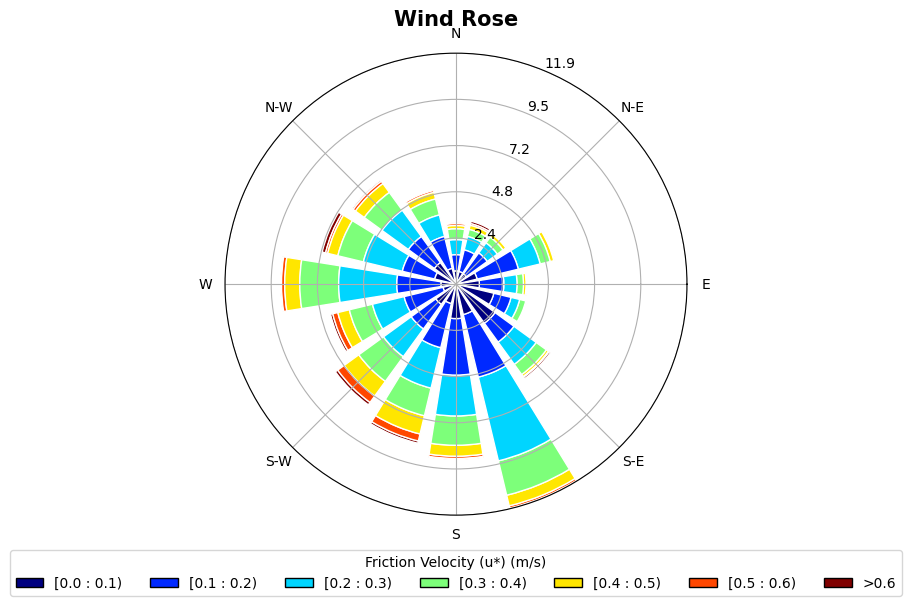

In [168]:
# Ensure that your DataFrame (co2_merged_df) includes columns "Year", "wind_dir", and "u*"
# Drop rows with missing values
data = co2_merged_df[["Year", "wind_dir", "u*"]].dropna()

# Define consistent bins for friction velocity (u*)
fixed_bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]  # Adjust these bins as necessary

# Create a single wind rose plot
fig = plt.figure(figsize=(6, 6))
ax = WindroseAxes.from_ax(fig.add_subplot(1, 1, 1, projection="windrose"))

# Plot the wind rose
bars = ax.bar(data['wind_dir'], data['u*'],
              normed=True, opening=0.8, edgecolor='white', cmap=plt.cm.jet, bins=fixed_bins)

# Add title and legend
ax.set_title("Wind Rose", fontsize=15, weight='bold', pad=20)
plt.legend(handles=ax.patches,
           labels=[f"[{fixed_bins[i]} ; {fixed_bins[i+1]}]" for i in range(len(fixed_bins)-1)] + [f">{fixed_bins[-1]}"],
           title="Friction Velocity (u*) (m/s)", loc='lower center', bbox_to_anchor=(0.5, -0.19), ncol=len(fixed_bins))

# Show plot
plt.show()



# █▓▒░ 📦 **6  Data screening and filtering** ░▒▓█

# ⚙️ **6.1 Filter 1:**
**CO₂ Flux Filtering Based on Bad Measurements**

### 🎯 **Objective**

Identify and replace invalid carbon dioxide (CO₂) flux data (`co2_flux`) with `NaN` values based on predefined quality flags:
- `0` → Good data  
- `1` → Bad data  
- `9` → Missing data  

### 📊 **Background**

The dataset includes three quality-control columns:  
`spikes_df`, `amplitude_resolution_hf`, and `absolute_limits_hf`.  
Each column contains nine-digit codes (e.g., `800000099` or `800000099.0`), where each digit represents a specific parameter — `u`, `v`, `w`, `ts`, `co2`, `h2o`, `ch4`, and `none`.

These codes are separated into individual columns such as:
`spikes_hf_u`, `spikes_hf_co2`, `absolute_limits_hf_none`, etc., for easier interpretation.

### ⚙️ **Process**

1. **Redistribution:**  
   Split and assign the coded QC values into new columns according to their parameters.

2. **Replacement:**  
   Substitute CO₂ flux values (`co2_flux`) with `NaN` wherever the related flag equals `1`, indicating a poor-quality measurement.

---

💡 *This step ensures that subsequent analyses only use reliable CO₂ flux data, improving the accuracy of flux filtering and carbon budget estimates.*

In [169]:
#df["spikes_hf"]                          # 8u/v/w/ts/co2/h2o/ch4/none
#df["amplitude_resolution_hf"]            # 8u/v/w/ts/co2/h2o/ch4/none
#df["absolute_limits_hf"]                  # 8u/v/w/ts/co2/h2o/ch4/none

### 4.1.1 Missing values checking before filtering

## ⚙️ **6.1.1 Spikes_hf (#8u / #v / #w / #ts / #co2 / #h2o / #ch4 / #none)**


In [170]:
mv_b_1st_filter = co2_df["co2_flux"].isnull().sum()
print(mv_b_1st_filter)

# Slice each string from the "spikes_hf" column and split it into individual characters
split_values = co2_df["spikes_hf"].astype(str).str[1:9].apply(lambda x: list(x))

# Convert the result to a DataFrame
split_values_df = pd.DataFrame(split_values.tolist(), index=co2_df.index, columns=['spikes_hf_u', 'spikes_hf_v', 'spikes_hf_w', 'spikes_hf_ts', 'spikes_hf_co2', 'spikes_hf_h2o', 'spikes_hf_ch4', 'spikes_hf_none']).apply(pd.to_numeric, errors='coerce')

# Create a mask for NaN values in the "spikes_hf" column
nan_mask = co2_df["spikes_hf"].isna()

# Assign NaN values to the entire DataFrame where "spikes_hf" column is NaN
split_values_df[nan_mask] = np.nan

# Update the original DataFrame with the new values
co2_df[['spikes_hf_u', 'spikes_hf_v', 'spikes_hf_w', 'spikes_hf_ts', 'spikes_hf_co2', 'spikes_hf_h2o', 'spikes_hf_ch4', 'spikes_hf_none']] = split_values_df[['spikes_hf_u', 'spikes_hf_v', 'spikes_hf_w', 'spikes_hf_ts', 'spikes_hf_co2', 'spikes_hf_h2o', 'spikes_hf_ch4', 'spikes_hf_none']]

# Display the updated DataFrame
#co2_df.head()

1893


## ⚙️ **6.1.2 Amplitude_resolution_hf (#8u / #v / #w / #ts / #co2 / #h2o / #ch4 / #none)**


In [171]:
# Slice each string from the "amplitude_resolution_hf" column and split it into individual characters
split_values_amplitude = co2_df["amplitude_resolution_hf"].astype(str).str[1:9].apply(lambda x: list(x))

# Convert the result to a DataFrame
split_values_amplitude_df = pd.DataFrame(split_values_amplitude.tolist(), index=co2_df.index, columns=['amplitude_resolution_hf_u', 'amplitude_resolution_hf_v', 'amplitude_resolution_hf_w', 'amplitude_resolution_hf_ts', 'amplitude_resolution_hf_co2', 'amplitude_resolution_hf_h2o', 'amplitude_resolution_hf_ch4', 'amplitude_resolution_hf_none']).apply(pd.to_numeric, errors='coerce')

# Create a mask for NaN values in the "amplitude_resolution_hf" column
nan_mask_amplitude = co2_df["amplitude_resolution_hf"].isna()

# Assign NaN values to the entire DataFrame where "amplitude_resolution_hf" column is NaN
split_values_amplitude_df[nan_mask_amplitude] = np.nan

# Update the original DataFrame with the new values
co2_df[['amplitude_resolution_hf_u', 'amplitude_resolution_hf_v', 'amplitude_resolution_hf_w', 'amplitude_resolution_hf_ts', 'amplitude_resolution_hf_co2', 'amplitude_resolution_hf_h2o', 'amplitude_resolution_hf_ch4', 'amplitude_resolution_hf_none']] = split_values_amplitude_df[['amplitude_resolution_hf_u', 'amplitude_resolution_hf_v', 'amplitude_resolution_hf_w', 'amplitude_resolution_hf_ts', 'amplitude_resolution_hf_co2', 'amplitude_resolution_hf_h2o', 'amplitude_resolution_hf_ch4', 'amplitude_resolution_hf_none']]

# Display the updated DataFrame
#co2_df.head()

## ⚙️ **6.1.3 Absolute_limits_hf (#8u / #v / #w / #ts / #co2 / #h2o / #ch4 / #none)**


In [172]:
# Slice each string from the "absolute_limits_hf" column and split it into individual characters
split_values_absolute = co2_df["absolute_limits_hf"].astype(str).str[1:9].apply(lambda x: list(x))

# Convert the result to a DataFrame
split_values_absolute_df = pd.DataFrame(split_values_absolute.tolist(), index=co2_df.index, columns=['absolute_limits_hf_u', 'absolute_limits_hf_v', 'absolute_limits_hf_w', 'absolute_limits_hf_ts', 'absolute_limits_hf_co2', 'absolute_limits_hf_h2o', 'absolute_limits_hf_ch4', 'absolute_limits_hf_none']).apply(pd.to_numeric, errors='coerce')

# Create a mask for NaN values in the "absolute_limits_hf" column
nan_mask_absolute = co2_df["absolute_limits_hf"].isna()

# Assign NaN values to the entire DataFrame where "absolute_limits_hf" column is NaN
split_values_absolute_df[nan_mask_absolute] = np.nan

# Update the original DataFrame with the new values
co2_df[['absolute_limits_hf_u', 'absolute_limits_hf_v', 'absolute_limits_hf_w', 'absolute_limits_hf_ts', 'absolute_limits_hf_co2', 'absolute_limits_hf_h2o', 'absolute_limits_hf_ch4', 'absolute_limits_hf_none']] = split_values_absolute_df[['absolute_limits_hf_u', 'absolute_limits_hf_v', 'absolute_limits_hf_w', 'absolute_limits_hf_ts', 'absolute_limits_hf_co2', 'absolute_limits_hf_h2o', 'absolute_limits_hf_ch4', 'absolute_limits_hf_none']]

# Display the updated DataFrame
#co2_df.head()

#### 📊 **6.1.4 Measurements_distribution_exploration**


In [173]:
# List of column names
columns = ['spikes_hf_u', 'spikes_hf_v', 'spikes_hf_w', 'spikes_hf_co2', 'absolute_limits_hf_u', 'absolute_limits_hf_v', 'absolute_limits_hf_w', 'absolute_limits_hf_co2', 'amplitude_resolution_hf_u', 'amplitude_resolution_hf_v', 'amplitude_resolution_hf_w', 'amplitude_resolution_hf_co2']

total_one = sum((co2_df[col] == 1).sum() for col in columns)
for col in columns:
    print(co2_df[col].value_counts())
    print("\n")

spikes_hf_u
0.0    12618
Name: count, dtype: int64


spikes_hf_v
0.0    12617
1.0        1
Name: count, dtype: int64


spikes_hf_w
0.0    12611
1.0        7
Name: count, dtype: int64


spikes_hf_co2
0.0    12608
1.0        7
9.0        3
Name: count, dtype: int64


absolute_limits_hf_u
0.0    12597
1.0       21
Name: count, dtype: int64


absolute_limits_hf_v
0.0    12597
1.0       21
Name: count, dtype: int64


absolute_limits_hf_w
0.0    12516
1.0      102
Name: count, dtype: int64


absolute_limits_hf_co2
0.0    12606
1.0        9
9.0        3
Name: count, dtype: int64


amplitude_resolution_hf_u
0.0    12615
1.0        3
Name: count, dtype: int64


amplitude_resolution_hf_v
0.0    12615
1.0        3
Name: count, dtype: int64


amplitude_resolution_hf_w
0.0    12610
1.0        8
Name: count, dtype: int64


amplitude_resolution_hf_co2
0.0    12613
9.0        3
1.0        2
Name: count, dtype: int64




## 🧯 **6.1.5 Replacing CO₂ Flux with NaN Values Due to Instrument Measurement Errors**


In [174]:
# Create a mask for rows where any of the specified columns is equal to 1
rowwise_mask = (co2_df[['spikes_hf_u', 'spikes_hf_v', 'spikes_hf_w', 'spikes_hf_co2', 'absolute_limits_hf_u', 'absolute_limits_hf_v', 'absolute_limits_hf_w', 'absolute_limits_hf_co2', 'amplitude_resolution_hf_u', 'amplitude_resolution_hf_v', 'amplitude_resolution_hf_w', 'amplitude_resolution_hf_co2']] == 1).any(axis=1)

# Replace values in co2_flux column with NaN where any of the specified columns is equal to 1
co2_df.loc[rowwise_mask, 'co2_flux'] = np.nan

## 📉 **6.1.6 Amount of Missing Values Checking After Filtering**


In [175]:
mv_a_1st_filter = co2_df["co2_flux"].isnull().sum()
print(mv_a_1st_filter)

print("\n")
print(f"Increase in missing values: {mv_a_1st_filter - mv_b_1st_filter}")

2012


Increase in missing values: 119


# ⚙️ **6.2 Filter 2:**
**Filtering based on qc_co2_flux flag**

### 🎯 **Objective**

The goal of this section is to ensure data quality by filtering out unreliable measurements.

Specifically:
- We filter the **CO₂ flux (`co2_flux`)** and **latent heat (`LE`)** data using the quality control variable **`qc_co2_flux`**.  
- Any record where **`qc_co2_flux` > 1** is considered low-quality and therefore replaced with **`NaN`** values in both `co2_flux` and `LE`.

This step helps maintain consistency and reliability in subsequent analyses.


## 🧹 **6.2.1 Filtering and Replacing `qc_co2_flux` > 1.0 with NaN**


In [176]:
mv_b_2nd_filter = co2_df["co2_flux"].isnull().sum() #Amount of missing values checking before filtering
print(mv_b_2nd_filter)

# Replace values in 'NEE' column where 'qc_co2_flux' > 1.0 with NaN
co2_df.loc[co2_df['qc_co2_flux'] > 1.0, 'co2_flux'] = np.nan
# Replace values in 'LE' column where 'qc_co2_flux' > 1.0 with NaN
co2_df.loc[co2_df['qc_co2_flux'] > 1.0, 'LE'] = np.nan

mv_a_2nd_filter = co2_df["co2_flux"].isnull().sum()
print(mv_a_2nd_filter)

print("\n")
print(f"Increase in missing values: {mv_a_2nd_filter - mv_b_2nd_filter}")

2012
4777


Increase in missing values: 2765


## 🌍 **6.3 Filter 3: Footprint Filtering with Google Earth Engine Using EC Fetch Distances**

This section focuses on filtering the **CO₂ flux (`co2_flux`)** based on the **flux footprint area**, commonly referred to as the *fetch*.

Using **Google Earth Engine (GEE)** integrated with **Python**, the method calculates distances corresponding to **relative footprint contributions** at **50%, 60%, 70%, and 80%** levels from the EddyPro full output data.

### ⚙️ **Process Overview**

1. **Generate a fetch dataset:**  
   Create an Excel file listing distances from the **Eddy Covariance (EC) Tower** to the edge of the footprint (*fetch*), measured every **10°**.

2. **Save the dataset:**  
   Store the complete Excel file for reference and later integration.

3. **Apply the filter:**  
   Use the fetch distance data and model outputs to **filter `co2_flux`** values, retaining only those within the defined footprint boundaries.

In [ ]:
print(f"Missing values before applying fetch filter: {co2_df['co2_flux'].isnull().sum()}")

# Load the fetch parameters file (fetches.xlsx)
fetches_df = pd.read_excel('fetches.xlsx')

# Load the dataset that contains co2_flux, wind_dir, and x_70%
data_df = co2_df.copy()
# Iterate through the dataset and compare with fetches data
for index, row in data_df.iterrows():
    wind_dir = row['wind_dir']
    x_70_percent = row['x_70%']

    # Iterate through the fetches file to find matching wind_dir range
    for _, fetch_row in fetches_df.iterrows():
        start_wd = fetch_row['Start_WD ']
        end_wd = fetch_row['End_WD']
        fetch_dist = fetch_row[' Fetch ']

        # Check if wind_dir falls in the range [Start_WD, End_WD]
        if start_wd <= wind_dir <= end_wd:
            # Check if the x_70% distance is more than Fetch distance
            if x_70_percent > fetch_dist:
                # Replace co2_flux with NaN
                data_df.at[index, 'co2_flux'] = np.nan
            # Break the loop once the match is found
            break

# Save the modified dataset (if needed)
data_df.to_csv('final.csv', index=False)  # Replace with your desired save path



print(f"Missing values after applying fetch filter: {data_df['co2_flux'].isnull().sum()}")


Missing values before applying fetch filter: 4777
Missing values after applying fetch filter: 5672


In [178]:
co2_df = data_df.copy()                                # The filtered dataset is "data_df"


# █▓▒░ 📦 **7  Exploratory Data Analysis (EDA) part 1** ░▒▓█

This section provides a concise summary of key statistical metrics — including the **minimum**, **maximum**, **mean**, and **median** — derived from the primary flux and storage variables: **CO₂**, **latent heat (LE)**, and **sensible heat (H)**.

These statistics offer a quick overview of data distribution and variability, helping to identify potential outliers or measurement inconsistencies before further analysis.

## 🏭 **7.1 CO₂ Storage**


In [179]:
cols = ['co2_strg', 'LE_strg', 'H_strg', 'co2_flux', 'LE', 'H']
col_stat = co2_df[cols].describe().round(2)
col_stat

,co2_strg,LE_strg,H_strg,co2_flux,LE,H
count,12042.00,12044.00,12050.00,8830.00,9820.00,11929.00
mean,0.01,-0.02,-0.00,0.41,28.12,27.07
std,0.42,0.85,2.81,2.11,55.38,321.87
min,-7.77,-6.29,-85.36,-83.04,-184.60,-1382.82
25%,-0.06,-0.41,-0.64,-0.24,-0.26,-9.21
50%,0.00,-0.00,-0.00,0.36,1.84,-0.45
75%,0.07,0.35,0.59,0.78,30.87,34.14
max,4.46,9.21,71.59,45.66,1052.57,24120.90



# █▓▒░ 📦 **8 Flux storage correction** ░▒▓█

This section aims to achieve the following objectives:

1. Incorporate storage changes into CO2, latent heat (LE), and sensible heat (H) fluxes. Any missing storage change values are standardized to 0.
2. Calculate Net Ecosystem Exchange (NEE), total latent heat (LE), and total sensible heat (H) by aggregating fluxes and storage changes.

In essence, these codes ensure that storage changes are appropriately factored into the flux calculations, resulting in the accurate determination of total fluxes (NEE, LE, and H) through the summation of fluxes and storage changes.

In [180]:
# Adding storage change to CO2 and heat fluxes (set missing storage change to 0)
co2_df.loc[co2_df['co2_strg'].isnull(),'co2_strg'] = 0
co2_df.loc[co2_df['LE_strg'].isnull(),'LE_strg'] = 0
co2_df.loc[co2_df['H_strg'].isnull(),'H_strg'] = 0

# Calculation of NEE, LE, and H
co2_df['NEE'] = co2_df['co2_flux'] + co2_df['co2_strg']
co2_df['LE'] = co2_df['LE'] + co2_df['LE_strg']
co2_df['H'] = co2_df['H'] + co2_df['H_strg']



# █▓▒░ 📦 **9 Outliers Removal** ░▒▓█

In [181]:
# Assuming co2_df is a pandas DataFrame and here are the columns of interest
columns_of_interest = [
    "air_temperature", "LE", "H", "RH", "RH_1_1_1",
    "TS_1_1_1", "NEE", "PPFD_1_1_1", "SWIN_1_1_1",
    "ET", "SWC_1_1_1", "VPD"
]

# Loop through each column in the list of columns of interest
for column in columns_of_interest:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile) for each column
    Q1 = co2_df[column].quantile(0.25)
    Q3 = co2_df[column].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace values outside the bounds with np.nan
    co2_df[column] = co2_df[column].mask((co2_df[column] < lower_bound) | (co2_df[column] > upper_bound))

# Now co2_df is updated, with outliers in the specified columns replaced by NaN

# █▓▒░ 📦 **10 Exploratory Data Analysis (EDA) part 2** ░▒▓█

In [182]:
# Generalize the name of the dataset as "df" for execution simplicity
df = co2_df.copy()

## 🌿 **10.1 NEE Visualization**


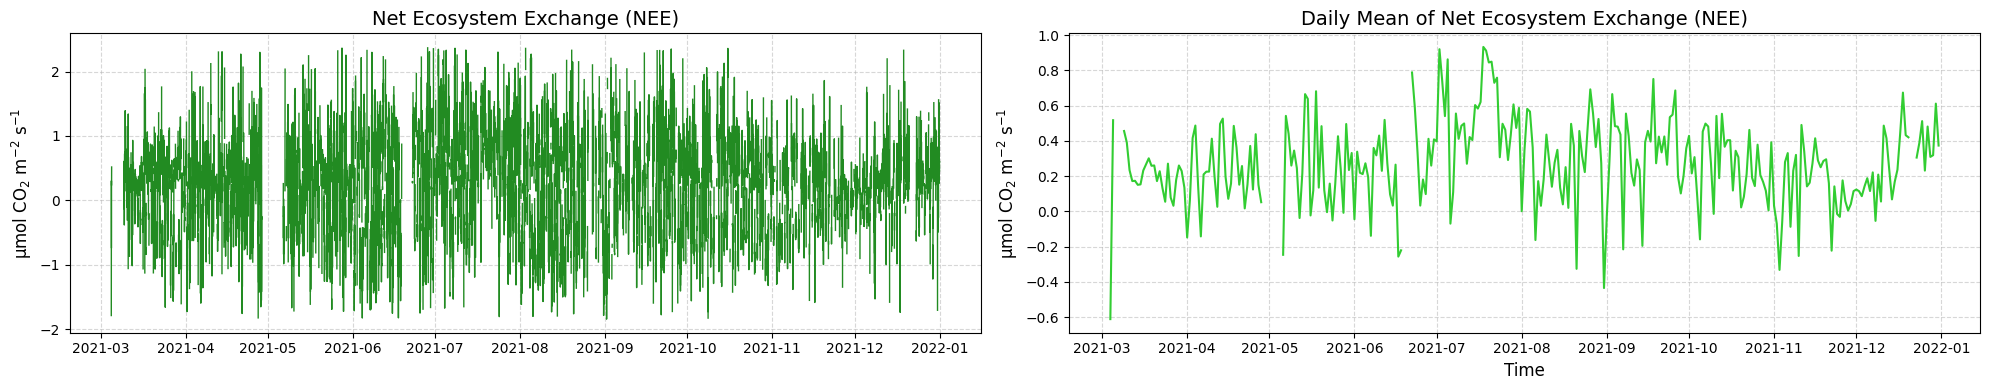

In [183]:
# --- Combined Subplots ---
plt.figure(figsize=(20, 4))

# Subplot 1: Raw NEE
plt.subplot(1, 2, 1)
plt.plot(df["NEE"], color='forestgreen', linewidth=1)
plt.title("Net Ecosystem Exchange (NEE)", fontsize=14)
plt.xlabel("")  # omit for top plot
plt.ylabel(r"µmol CO$_2$ m$^{-2}$ s$^{-1}$", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)


# Subplot 2: Daily Mean NEE
# Compute daily mean
daily_nee = df['NEE'].resample('D').mean()
plt.subplot(1, 2, 2)
plt.plot(daily_nee, color='limegreen', linewidth=1.5)
plt.title("Daily Mean of Net Ecosystem Exchange (NEE)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel(r"µmol CO$_2$ m$^{-2}$ s$^{-1}$", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [184]:
'''
print(f"Min: {df['NEE'].min()}")
print(f"Mean: {df['NEE'].mean()}")
print(f"Max: {df['NEE'].max()}")
print(f"Median: {df['NEE'].median()}")
print("\n")
print(f"Lower values\nScreening:\n {df['NEE'][df['NEE'] < -25]}\n")
print(f"Screening, total: {df['NEE'][df['NEE'] < -25].value_counts().sum()}\n")
print("\n")
print(f"Screening:\n {df['NEE'][df['NEE'] > 25]}\n")
print(f"Screening, total: {df['NEE'][df['NEE'] > 25].value_counts().sum()}")
'''

'\nprint(f"Min: {df[\'NEE\'].min()}")\nprint(f"Mean: {df[\'NEE\'].mean()}")\nprint(f"Max: {df[\'NEE\'].max()}")\nprint(f"Median: {df[\'NEE\'].median()}")\nprint("\n")\nprint(f"Lower values\nScreening:\n {df[\'NEE\'][df[\'NEE\'] < -25]}\n")\nprint(f"Screening, total: {df[\'NEE\'][df[\'NEE\'] < -25].value_counts().sum()}\n")\nprint("\n")\nprint(f"Screening:\n {df[\'NEE\'][df[\'NEE\'] > 25]}\n")\nprint(f"Screening, total: {df[\'NEE\'][df[\'NEE\'] > 25].value_counts().sum()}")\n'

## 🌿 **10.2 H Visualization**


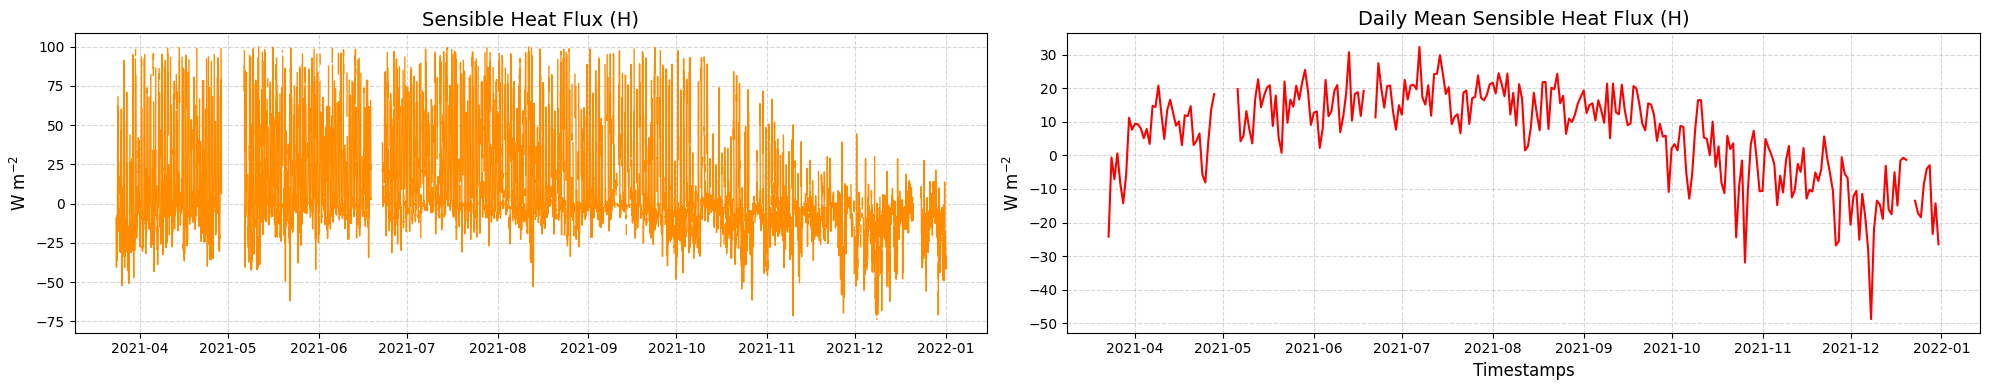

In [185]:
# --- Combined Subplots ---
plt.figure(figsize=(20, 4))

# Subplot 1: Raw Sensible Heat Flux
plt.subplot(1, 2, 1)
plt.plot(df["H"], color='darkorange', linewidth=1)
plt.title("Sensible Heat Flux (H)", fontsize=14)
plt.xlabel("")  # remove x-label to avoid overlap
plt.ylabel(r"W m$^{-2}$", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

# Subplot 2: Daily Mean Sensible Heat Flux
# Compute daily mean
daily_H = df['H'].resample('D').mean()
plt.subplot(1, 2, 2)
plt.plot(daily_H, color='red', linewidth=1.5)
plt.title("Daily Mean Sensible Heat Flux (H)", fontsize=14)
plt.xlabel("Timestamps", fontsize=12)
plt.ylabel(r"W m$^{-2}$", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [186]:
'''
print(f"Min: {df['H'].min()}")
print(f"Mean: {df['H'].mean()}")
print(f"Max: {df['H'].max()}")
print(f"Median: {df['H'].median()}")

print(f"Screening:\n {df['H'][df['H'] < -20]}\n")
print(f"Screening, total: {df['H'][df['H'] < -20].value_counts().sum()}")

print(f"Screening:\n {df['H'][df['H'] > 100]}\n")
print(f"Screening, total: {df['H'][df['H'] > 100].value_counts().sum()}")
'''

'\nprint(f"Min: {df[\'H\'].min()}")\nprint(f"Mean: {df[\'H\'].mean()}")\nprint(f"Max: {df[\'H\'].max()}")\nprint(f"Median: {df[\'H\'].median()}")\n\nprint(f"Screening:\n {df[\'H\'][df[\'H\'] < -20]}\n")\nprint(f"Screening, total: {df[\'H\'][df[\'H\'] < -20].value_counts().sum()}")\n\nprint(f"Screening:\n {df[\'H\'][df[\'H\'] > 100]}\n")\nprint(f"Screening, total: {df[\'H\'][df[\'H\'] > 100].value_counts().sum()}")\n'

## 🌿 **10.3 LE Visualization**


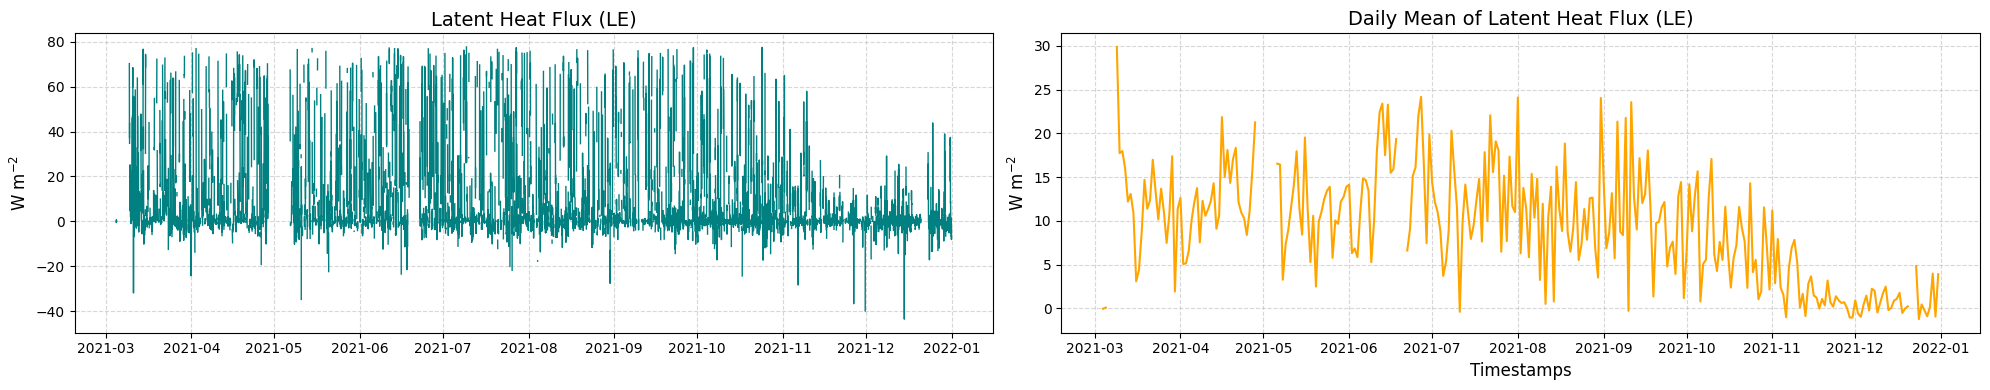

In [187]:
# --- Plot both in subplots ---
plt.figure(figsize=(20, 4))

# Subplot 1: Raw LE
plt.subplot(1, 2, 1)
plt.plot(df["LE"], color='teal', linewidth=1)
plt.title("Latent Heat Flux (LE)", fontsize=14)
plt.xlabel("")  # No xlabel for top plot
plt.ylabel(r"W m$^{-2}$", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)


# Subplot 2: Daily Mean LE
# Daily mean
daily_LE = df['LE'].resample('D').mean()
plt.subplot(1, 2, 2)
plt.plot(daily_LE, color='orange', linewidth=1.5)
plt.title("Daily Mean of Latent Heat Flux (LE)", fontsize=14)
plt.xlabel("Timestamps", fontsize=12)
plt.ylabel(r"W m$^{-2}$", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

# Layout adjustment
plt.tight_layout()
plt.show()

In [188]:
'''
print(f"Min: {df['LE'].min()}")
print(f"Mean: {df['LE'].mean()}")
print(f"Max: {df['LE'].max()}")
print(f"Median: {df['LE'].median()}")

print(f"Screening:\n {df['LE'][df['LE'] < -20]}\n")
print(f"Screening, total: {df['LE'][df['LE'] < -20].value_counts().sum()}")

print(f"Screening:\n {df['LE'][df['LE'] > 80]}\n")
print(f"Screening, total: {df['LE'][df['LE'] > 80].value_counts().sum()}")
'''

'\nprint(f"Min: {df[\'LE\'].min()}")\nprint(f"Mean: {df[\'LE\'].mean()}")\nprint(f"Max: {df[\'LE\'].max()}")\nprint(f"Median: {df[\'LE\'].median()}")\n\nprint(f"Screening:\n {df[\'LE\'][df[\'LE\'] < -20]}\n")\nprint(f"Screening, total: {df[\'LE\'][df[\'LE\'] < -20].value_counts().sum()}")\n\nprint(f"Screening:\n {df[\'LE\'][df[\'LE\'] > 80]}\n")\nprint(f"Screening, total: {df[\'LE\'][df[\'LE\'] > 80].value_counts().sum()}")\n'

## 🌿 **10.4 NEE Visualization**


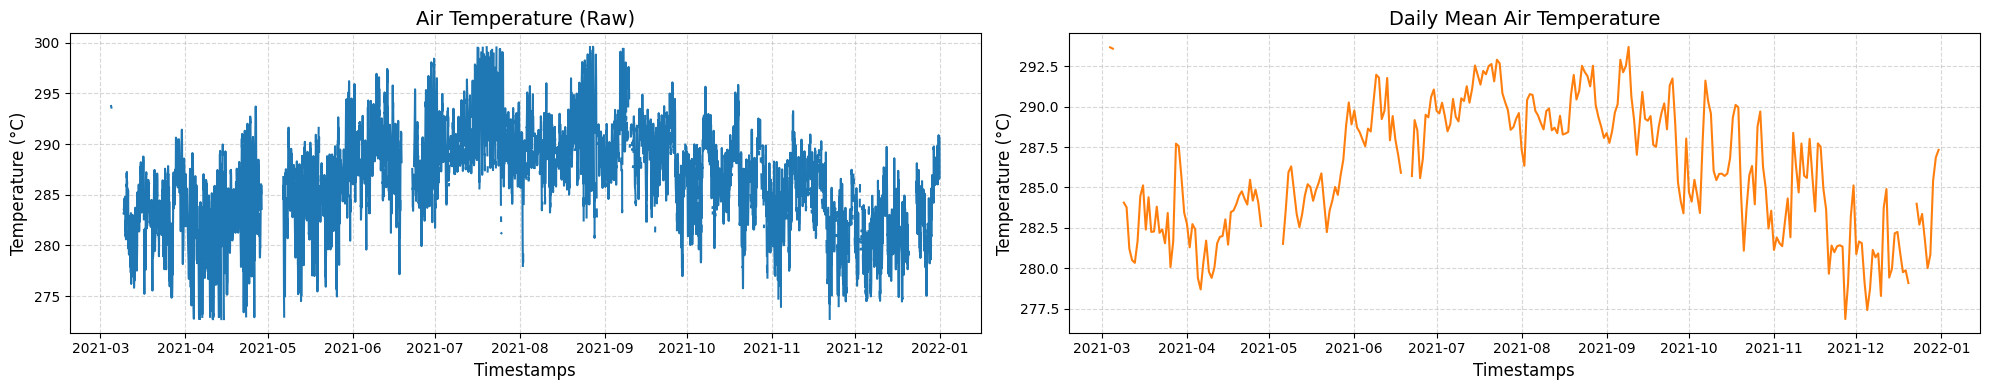

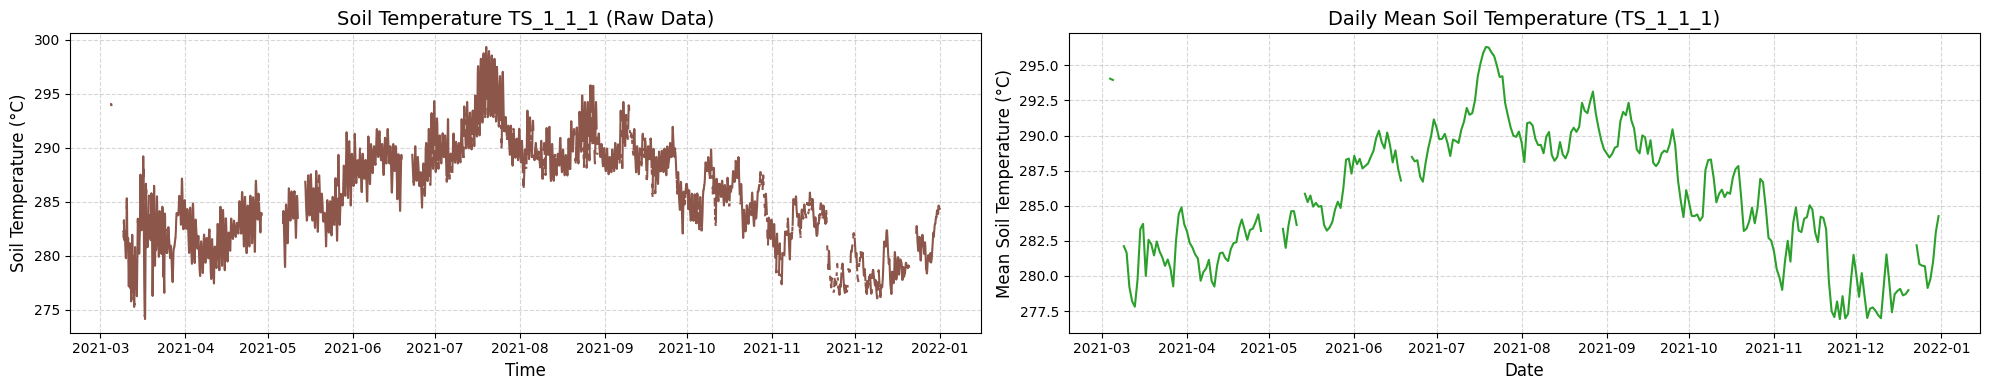

In [189]:
# --- Plot Air Temperature (Raw + Daily Mean) ---
plt.figure(figsize=(20, 4))

# 1st subplot - Raw Air Temperature
plt.subplot(1, 2, 1)
plt.plot(df["air_temperature"], color='tab:blue')
plt.title("Air Temperature (Raw)", fontsize=14)
plt.xlabel("Timestamps", fontsize=12)
plt.ylabel(r"Temperature (°C)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

# 2nd subplot - Daily Mean Air Temperature
daily_ta = df['air_temperature'].resample('D').mean()
plt.subplot(1, 2, 2)
plt.plot(daily_ta, color='tab:orange')
plt.title("Daily Mean Air Temperature", fontsize=14)
plt.xlabel("Timestamps", fontsize=12)
plt.ylabel(r"Temperature (°C)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# --- Plot Soil Temperature (Raw + Daily Mean) ---
plt.figure(figsize=(20, 4))

# Raw Soil Temperature
plt.subplot(1, 2, 1)
plt.plot(df["TS_1_1_1"], color='tab:brown')
plt.title("Soil Temperature TS_1_1_1 (Raw Data)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Soil Temperature (°C)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

# Daily Mean Soil Temperature
daily_ts = df["TS_1_1_1"].resample("D").mean()
plt.subplot(1, 2, 2)
plt.plot(daily_ts, color='tab:green')
plt.title("Daily Mean Soil Temperature (TS_1_1_1)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Mean Soil Temperature (°C)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [190]:
# Convert temperatures from Kelvin to Celsius
df['TS_1_1_1'] = df['TS_1_1_1'] - 273.15
df['air_temperature'] = df['air_temperature'] - 273.15

## 🌿 **10.5 Relative humidity (RH and RH_1_1_1) Visualization**

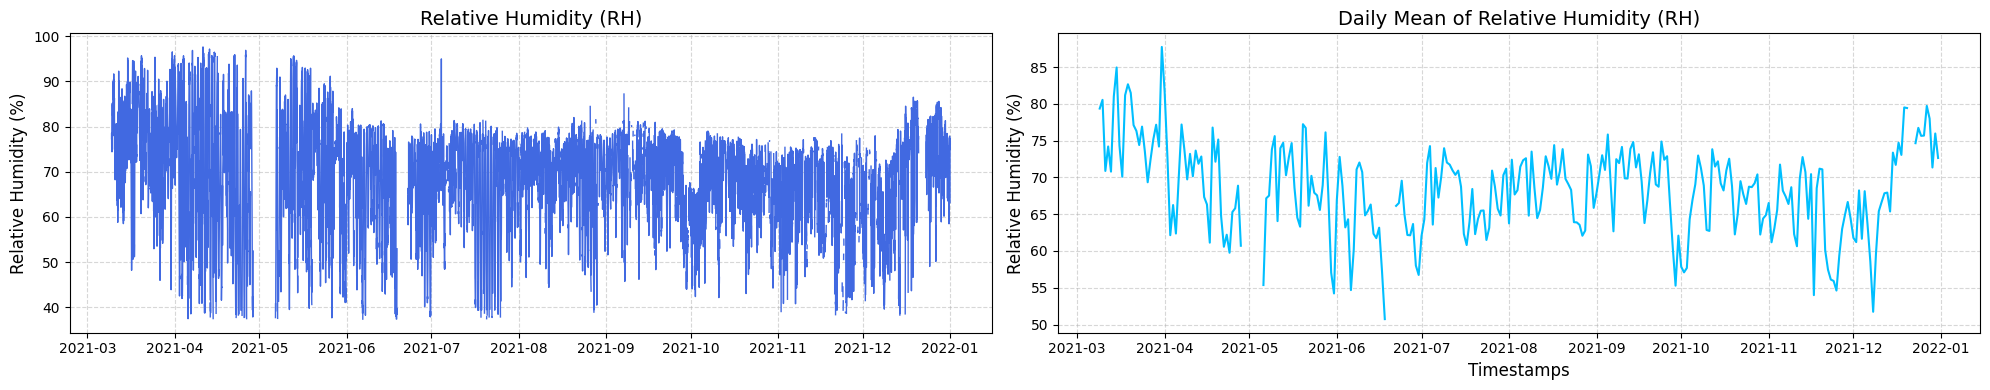

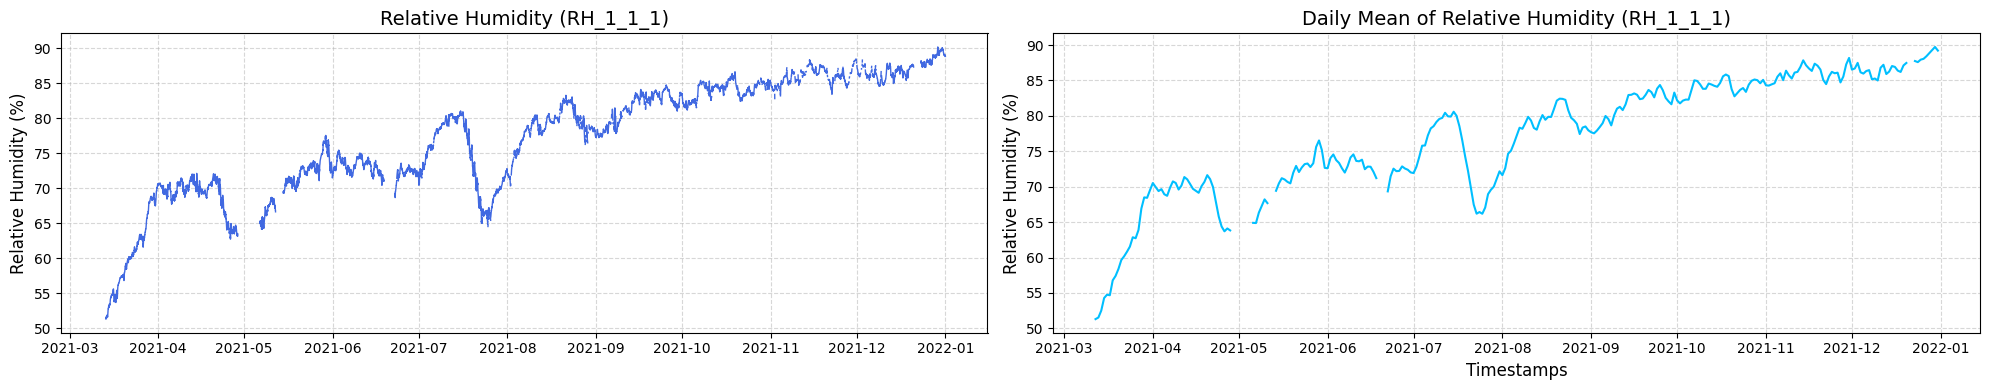

In [191]:
# Compute daily mean
daily_RH = df['RH'].resample('D').mean()

# --- Combined Subplots ---
plt.figure(figsize=(20, 4))

# Subplot 1: Raw RH
plt.subplot(1, 2, 1)
plt.plot(df["RH"], color='royalblue', linewidth=1)
plt.title("Relative Humidity (RH)", fontsize=14)
plt.xlabel("")  # omit to prevent overlap
plt.ylabel("Relative Humidity (%)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

# Subplot 2: Daily Mean RH
plt.subplot(1, 2, 2)
plt.plot(daily_RH, color='deepskyblue', linewidth=1.5)
plt.title("Daily Mean of Relative Humidity (RH)", fontsize=14)
plt.xlabel("Timestamps", fontsize=12)
plt.ylabel("Relative Humidity (%)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()



# RH_1_1_1
# Compute daily mean
daily_RH = df['RH_1_1_1'].resample('D').mean()

# --- Combined Subplots ---
plt.figure(figsize=(20, 4))

# Subplot 1: Raw RH
plt.subplot(1, 2, 1)
plt.plot(df["RH_1_1_1"], color='royalblue', linewidth=1)
plt.title("Relative Humidity (RH_1_1_1)", fontsize=14)
plt.xlabel("")  # omit to prevent overlap
plt.ylabel("Relative Humidity (%)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

# Subplot 2: Daily Mean RH
plt.subplot(1, 2, 2)
plt.plot(daily_RH, color='deepskyblue', linewidth=1.5)
plt.title("Daily Mean of Relative Humidity (RH_1_1_1)", fontsize=14)
plt.xlabel("Timestamps", fontsize=12)
plt.ylabel("Relative Humidity (%)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

## 🌿 **10.6 Shortwave Incoming Radiation (SWIN) Visualization**

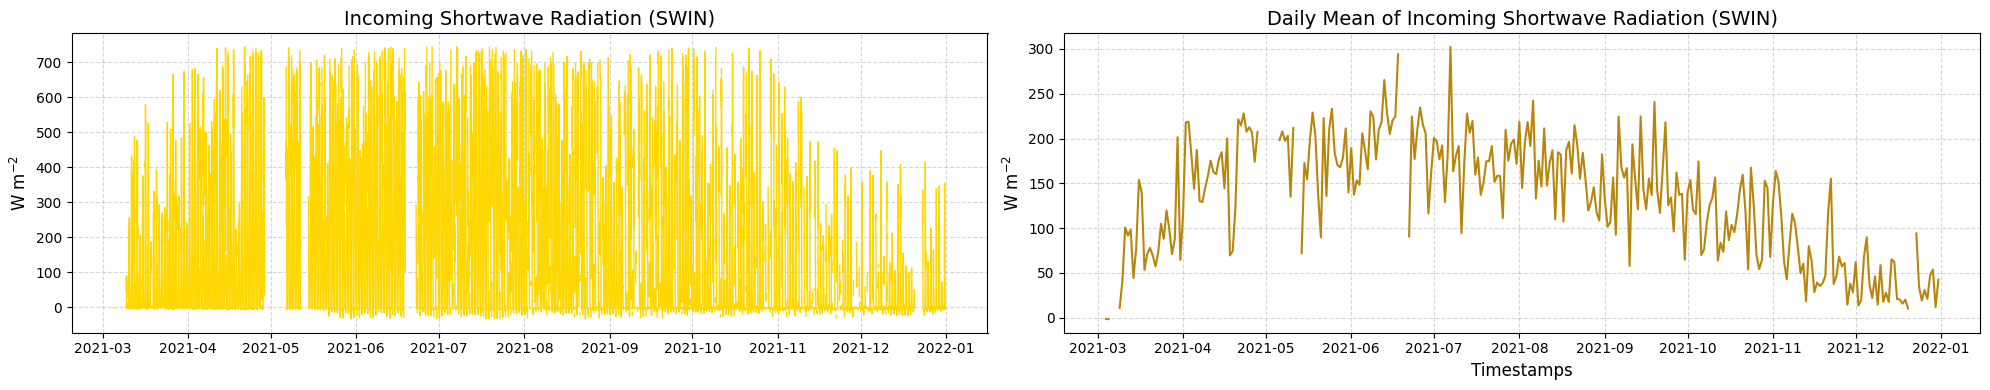

In [192]:
# Compute daily mean
daily_swin = df['SWIN_1_1_1'].resample('D').mean()

# --- Combined Subplots ---
plt.figure(figsize=(20, 4))

# Subplot 1: Raw Incoming Shortwave Radiation
plt.subplot(1, 2, 1)
plt.plot(df["SWIN_1_1_1"], color='gold', linewidth=1)
plt.title("Incoming Shortwave Radiation (SWIN)", fontsize=14)
plt.xlabel("")  # omit x-label for top subplot
plt.ylabel(r"W m$^{-2}$", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

# Subplot 2: Daily Mean Incoming Shortwave Radiation
plt.subplot(1, 2, 2)
plt.plot(daily_swin, color='darkgoldenrod', linewidth=1.5)
plt.title("Daily Mean of Incoming Shortwave Radiation (SWIN)", fontsize=14)
plt.xlabel("Timestamps", fontsize=12)
plt.ylabel(r"W m$^{-2}$", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

## 🌿 **10.7 VPD Visualization**

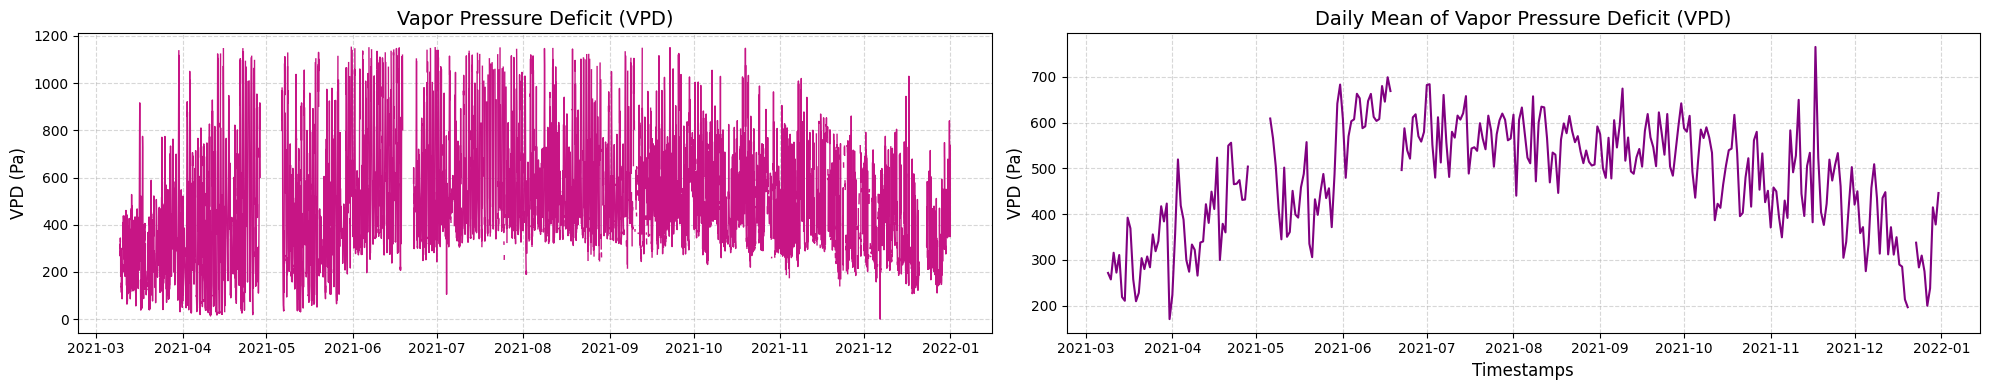

In [193]:
# Compute daily mean
daily_vpd = df['VPD'].resample('D').mean()

# --- Combined Subplots ---
plt.figure(figsize=(20, 4))

# Subplot 1: Raw VPD
plt.subplot(1, 2, 1)
plt.plot(df["VPD"], color='mediumvioletred', linewidth=1)
plt.title("Vapor Pressure Deficit (VPD)", fontsize=14)
plt.xlabel("")  # omit x-label for top plot
plt.ylabel("VPD (Pa)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

# Subplot 2: Daily Mean VPD
plt.subplot(1, 2, 2)
plt.plot(daily_vpd, color='purple', linewidth=1.5)
plt.title("Daily Mean of Vapor Pressure Deficit (VPD)", fontsize=14)
plt.xlabel("Timestamps", fontsize=12)
plt.ylabel("VPD (Pa)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [194]:
# Update df["VPD"] where values are less than 0 to np.nan
df.loc[df["VPD"] < 0, "VPD"] = np.nan                                      # VPD below 0 is assigned as np.nan

df["VPD"] = df["VPD"]/1000  # convert from hPa → kPa

## 🌿 **10.7 Soil Water Content (SWC) Visualization**

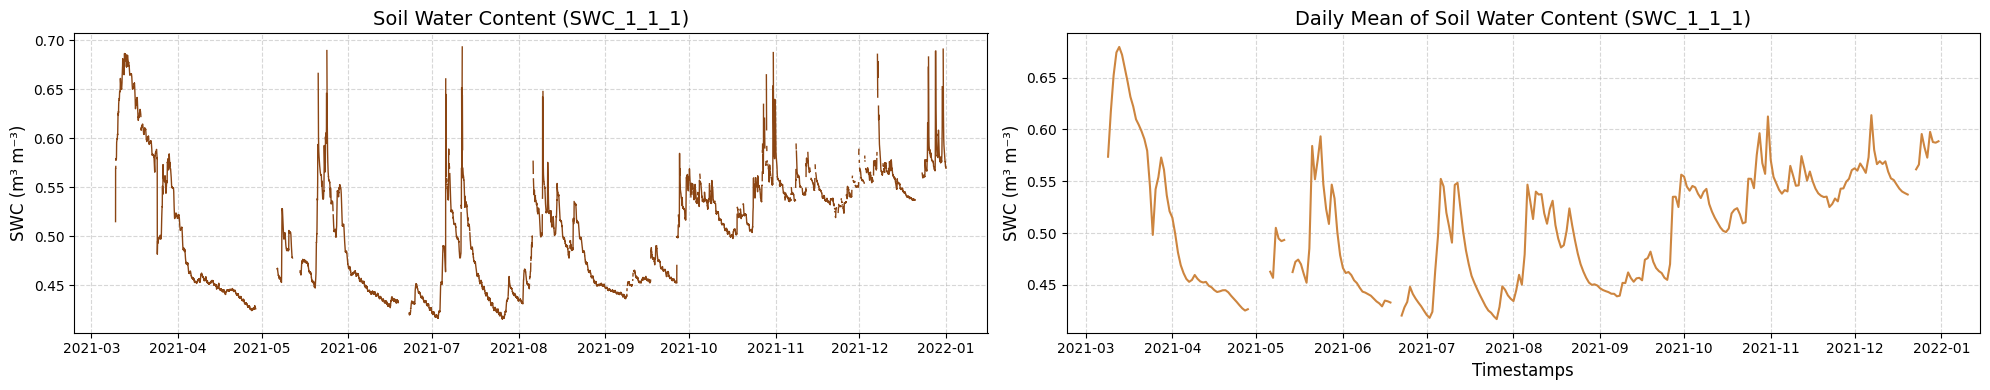

In [195]:
# --- Compute daily mean ---
daily_swc = df['SWC_1_1_1'].resample('D').mean()

# --- Side-by-side subplots ---
fig, axs = plt.subplots(1, 2, figsize=(20, 4))

# Left plot: Raw SWC
axs[0].plot(df["SWC_1_1_1"], color='saddlebrown', linewidth=1)
axs[0].set_title("Soil Water Content (SWC_1_1_1)", fontsize=14)
axs[0].set_xlabel("")
axs[0].set_ylabel("SWC (m³ m⁻³)", fontsize=12)
axs[0].grid(True, linestyle="--", alpha=0.5)

# Right plot: Daily Mean SWC
axs[1].plot(daily_swc, color='peru', linewidth=1.5)
axs[1].set_title("Daily Mean of Soil Water Content (SWC_1_1_1)", fontsize=14)
axs[1].set_xlabel("Timestamps", fontsize=12)
axs[1].set_ylabel("SWC (m³ m⁻³)", fontsize=12)
axs[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [196]:
df['SWC_1_1_1'] = df['SWC_1_1_1'] * 100  # Soil moisture content, decimal to %

In [197]:
#df["P_RAIN_1_1_1"] = df["P_RAIN_1_1_1"]*1000

In [198]:
# Foot print analysis
#ft = df.copy()


# █▓▒░ 📦 **11 Processed and clean data before Gap-filling by ReddyPro** ░▒▓█

In [199]:
# Processed, filtered (all filters including the fetch distance filter), not gap-filled data
# Define the filename for the CSV file
df.to_csv("2 EC_processed_cleaned_data.csv")
co2_processed_clean_data = df.copy()
meteorological_condition = df.copy()
co2_processed_clean_data.to_csv("meteorological_condition.csv")

In [200]:
co2_processed_clean_data.shape

(14502, 263)


# █▓▒░ 📦 **12 Data for Gap-filling by ReddyProc package** ░▒▓█

## 🧾 **12.1 Columns for REddyProc**


In [201]:
# Define columns of interest
columns_of_interest = ["Year", "Hour", "DoY", "NEE", "LE", "H", "u*", "qc_co2_flux", "qc_h2o_flux",
                       "RN_1_1_1", "air_temperature", "RH_1_1_1", "SWIN_1_1_1", "TS_1_1_1", "VPD"]

# Subset the DataFrame with the columns of interest
subset_df = df[columns_of_interest]
df = subset_df.copy()        # copy
#df.head()

In [202]:
'''
# Load your actual dataset
subset_df = subset_df  # Assuming the subset dataset is already loaded as 'subset_df'

# Set the figure size
plt.figure(figsize=(14, 14))

# Get all parameters from the dataset
parameters = [col for col in subset_df.columns if col not in ['Year', 'Season']]
valid_colors = sns.color_palette('husl', len(parameters))  # Dynamically generate enough colors

# Iterate through each parameter to create a boxplot for outlier screening
for i, parameter in enumerate(parameters):
    plt.subplot((len(parameters) + 1) // 2, 2, i + 1)  # Adjust grid layout based on number of parameters
    sns.boxplot(y=subset_df[parameter], palette=[valid_colors[i]])
    plt.title(parameter)
    plt.ylabel(parameter)

plt.tight_layout()
plt.show()
'''

"\n# Load your actual dataset\nsubset_df = subset_df  # Assuming the subset dataset is already loaded as 'subset_df'\n\n# Set the figure size\nplt.figure(figsize=(14, 14))\n\n# Get all parameters from the dataset\nparameters = [col for col in subset_df.columns if col not in ['Year', 'Season']]\nvalid_colors = sns.color_palette('husl', len(parameters))  # Dynamically generate enough colors\n\n# Iterate through each parameter to create a boxplot for outlier screening\nfor i, parameter in enumerate(parameters):\n    plt.subplot((len(parameters) + 1) // 2, 2, i + 1)  # Adjust grid layout based on number of parameters\n    sns.boxplot(y=subset_df[parameter], palette=[valid_colors[i]])\n    plt.title(parameter)\n    plt.ylabel(parameter)\n\nplt.tight_layout()\nplt.show()\n"

## 🧾 **12.2 Required header rows**

In [203]:
# construct header rows for the resulting datafile, rename some columns
# Make sure the best data quality is checked (for example RH_1_1_1 instead RH) from Biomet
header_rows = pd.DataFrame([len(df.columns)*['--']], columns=df.columns)
header_rows.rename(columns={"SWIN_1_1_1" : "Rg", "RH_1_1_1" : "rH","u*": "Ustar",
                          "air_temperature" : "Tair", "TS_1_1_1" : "Tsoil", "RN_1_1_1" : "Net" }, inplace=True)
print(header_rows)

  Year Hour DoY NEE  LE   H Ustar qc_co2_flux qc_h2o_flux Net Tair  rH  Rg  \
0   --   --  --  --  --  --    --          --          --  --   --  --  --   

  Tsoil VPD  
0    --  --  


## 🧮 **12.3 Dataset for REddyProc**

In [ ]:
# Saving as a tab-separated text file with unit placeholders in the second row
res_file_txt = "AsiaFlux2025.txt"
header_rows.to_csv(res_file_txt, sep='\t', index=False)
df.to_csv(res_file_txt, mode='a', sep='\t', na_rep='-9999', header=False, index=False)

# Saving as a CSV file with unit placeholders in the second row
res_file_csv = "AsiaFlux2025.csv"
header_rows.to_csv(res_file_csv, sep='\t', index=False)
df.to_csv(res_file_csv, mode='a', sep='\t', na_rep='-9999', header=False, index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>